In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.plotly as py
#import datetime
import time
#import math
import pyodbc
sns.set_style("whitegrid")

In [2]:
taglistfile = 'C:\\Users\meclijda\Documents\TagList.csv'
dfTags = pd.read_csv(taglistfile,";",encoding = "ISO-8859-1")
tagList = dfTags['Tag'].tolist()
print(str(len(tagList))+ ' tags in the taglist.')
#print(dfTags['Tag'].head())
#print(list(set([x for x in tagList if tagList.count(x) > 1])))

62 tags in the taglist.


In [3]:
# read IP21 tag data
strAsOfDate = '24-AUG-15 11:40:00.0'
strUpToDate = '28-DEC-16 00:00:00.0'
pattern = '%d-%b-%y %H:%M:%S.0'
#epochstart = int(time.mktime(time.strptime(strAsOfDate, pattern)))

start_time = time.time()

strConnect = 'DSN=PO_ODBC'
cnn = pyodbc.connect(strConnect)

#print(tagList[0])
df = pd.DataFrame()
for i, strTagName in enumerate(tagList):
    ts = time.time()
    print(str(i) + ': getting data from tag ' + strTagName + ' ...')
    sql = "select TS_START, AVG from aggregates "\
        "where name = '" + strTagName + "' "\
        "and TS between '" + strAsOfDate + "' and '" + strUpToDate + "' "\
        "and period = 1:00;"
    #print(sql)
    data1 = pd.read_sql(sql, cnn)
    data1['TS_START'] = pd.to_datetime(data1['TS_START'],utc=True)
    #data1['TS_START'] = data1['TS_START'].apply(lambda x: x.strftime('%Y-%m-%dT%H:%M:%SZ'))
    data1.set_index('TS_START',inplace=True)
    data1.columns = [strTagName]
    #data1.to_csv(strTagName.replace(":","_") + '.csv')
    #data2 = data1.resample('1H', how='mean')
    #print(str(data1.count())+" - "+str(data1.mean()))
    df = pd.concat([df, data1], axis=1)
    print('    data loaded in %s seconds' % (time.time()-ts))

cnn.close
elapsed_time = time.time() - start_time
print('Total elapsed time: %s seconds.' % elapsed_time)
#print(df.describe())

0: getting data from tag POARFQCA-17901:me ...
    data loaded in 21.918087005615234 seconds
1: getting data from tag POARAIA-17903_1a:av ...
    data loaded in 16.96581768989563 seconds
2: getting data from tag POARAIA-17903_3a:av ...
    data loaded in 18.21560263633728 seconds
3: getting data from tag POARTC-17902:me ...
    data loaded in 17.13766312599182 seconds
4: getting data from tag POARAIA-17903_2ab:av ...
    data loaded in 12.669685125350952 seconds
5: getting data from tag POARTI-17912:av ...
    data loaded in 16.09096908569336 seconds
6: getting data from tag POARFCA-17907:me ...
    data loaded in 16.465904235839844 seconds
7: getting data from tag POARTC-17923:me ...
    data loaded in 20.371479034423828 seconds
8: getting data from tag POARTCA-17931:me ...
    data loaded in 16.653371810913086 seconds
9: getting data from tag POARFIA-17904:av ...
    data loaded in 21.293195009231567 seconds
10: getting data from tag POARTCA-17922:me ...
    data loaded in 16.8252170

#### Create filter for steady state
* POARFQCA-17901:me (C6-feed t/h) * POARAIA-17903_1a:av (DA901 Feed C6H6 p-%) >= 15t/h

In [4]:
df_filter = pd.DataFrame()
df['BzFeed'] = df['POARFQCA-17901:me']*df['POARAIA-17903_1a:av']/100
df_filter['Filter_BzFeed_gt15'] = df['BzFeed']>=14.95
print(df_filter['Filter_BzFeed_gt15'].describe())

count     11797
unique        2
top        True
freq       9876
Name: Filter_BzFeed_gt15, dtype: object


#### Plot timeseries
* a timeplot with associated histogram is plotted for each tag.
* the red line represents the mean of the data ignoring the zero-values.
* the green area represents the steady state production as definied by the filter above. red is non steady-state.

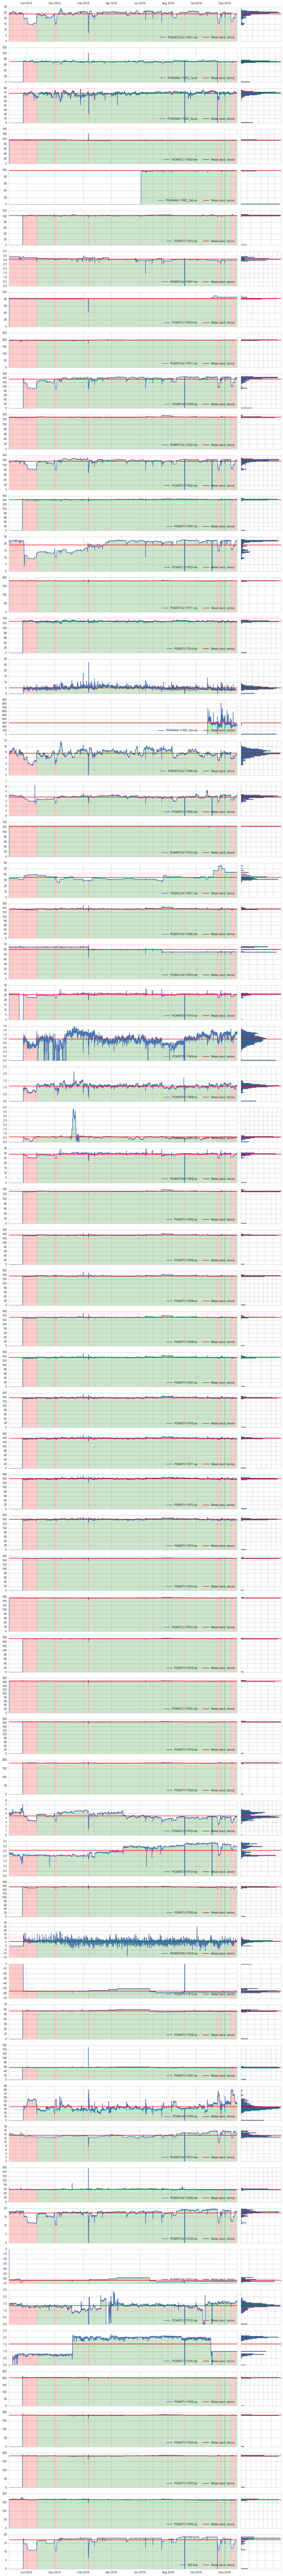

In [5]:
def plottimeseries(df):
    numSubPlots = len(df.columns)
    f, axarr = plt.subplots(nrows=numSubPlots, ncols=2, figsize=(14,numSubPlots*2), gridspec_kw = {'width_ratios':[17, 3]})
    for i, tag in enumerate(df.columns):
        axarr[i,0].plot(df.index, df[tag])
        axarr[i,0].axhline(y = df[tag][df[tag]!=0].mean(), color = 'r',label='Mean (excl. zeros)')
        axarr[i,0].fill_between(df.index,y1=axarr[i,0].get_ylim()[0],y2=df[tag],where=df_filter['Filter_BzFeed_gt15']==False,color='r',alpha=0.2)
        axarr[i,0].fill_between(df.index,y1=axarr[i,0].get_ylim()[0],y2=df[tag],where=df_filter['Filter_BzFeed_gt15']==True,color='g',alpha=0.2)
        axarr[i,0].legend(loc='lower right',ncol=2)
        if (i!=numSubPlots-1 and i!=0):
            axarr[i,0].xaxis.set_ticklabels([])
        if i==0:
            axarr[i,0].xaxis.tick_top()
        axarr[i,1].hist(df[tag],bins=50,normed=True,orientation='horizontal')
        axarr[i,1].axhline(y = df[tag][df[tag]!=0].mean(), color = 'r',label='Mean (excl. zeros)')
        axarr[i,1].xaxis.set_ticklabels([])
        axarr[i,1].yaxis.set_ticklabels([])
    plt.tight_layout()
        
plottimeseries(df)

#### Plotting a heatmap of correlations
* for the first 20 variables the Pearson correlation coefficient is plotted.

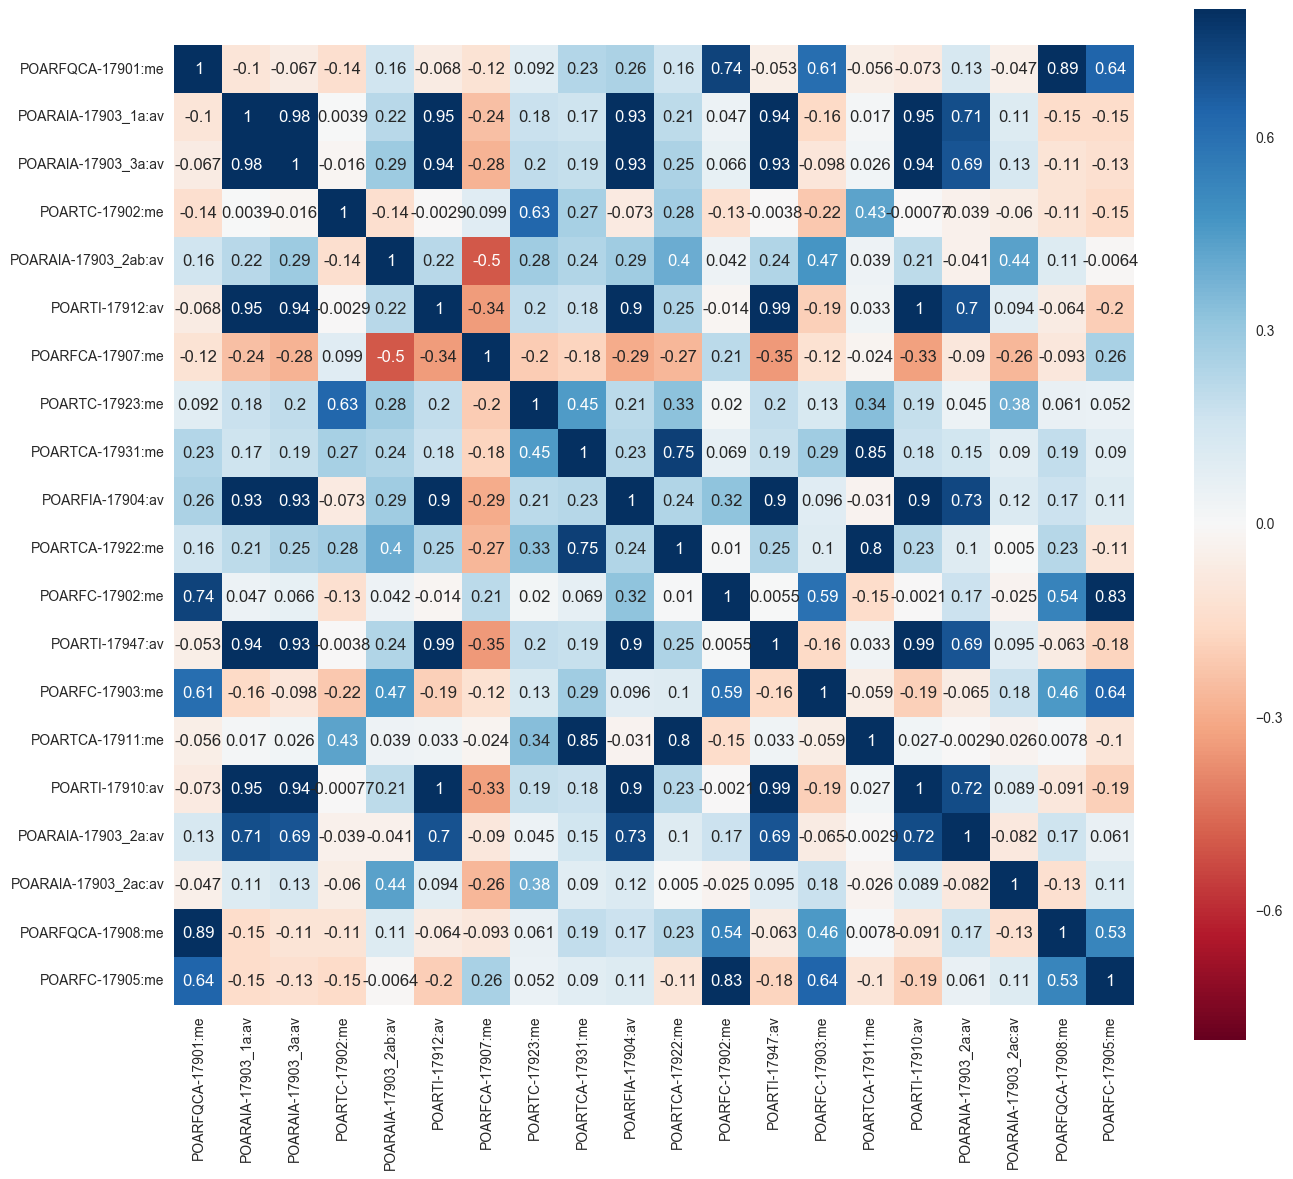

In [6]:
corrmat = df.corr()
f, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(corrmat.ix[:20, :20], vmax=.8, square=True, yticklabels=True, annot=True,cmap="RdBu")
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

#### Plotting of rolling correlations
* For 2 variables a rolling correlations is plotted. The sliding window is put to 50 data points.
* This is used to see if correlation stays stable in time.

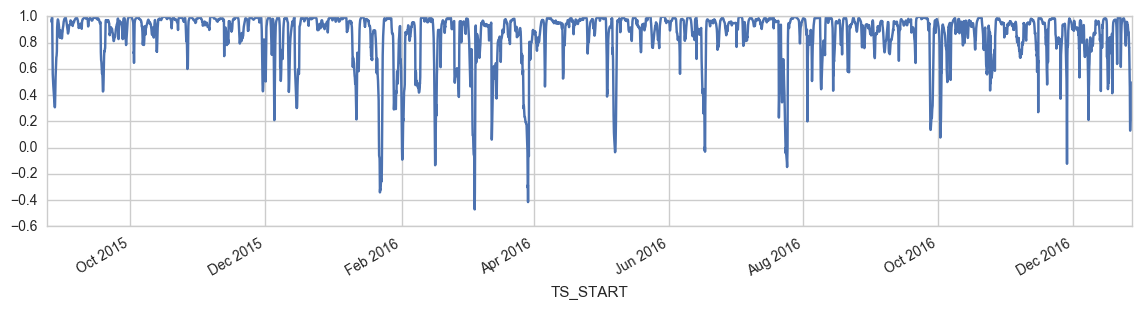

POARFQCA-17901:me - POARFQCA-17908:me


In [7]:
correls = df.rolling(window=50).corr()
plt.figure(figsize=(14,3))
correls.loc[:, df.columns[0], df.columns[18]].plot()
plt.show()
print(df.columns[0] + " - " + df.columns[18])

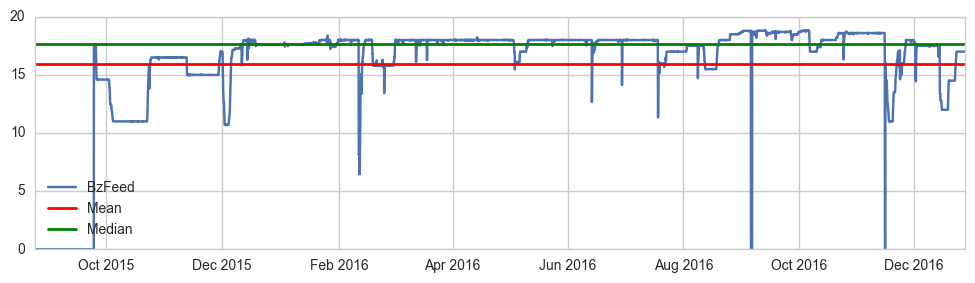

In [8]:
strTagName='BzFeed'
plt.figure(figsize=(12,3))
plt.plot(df.index,df[strTagName],label=strTagName)
plt.axhline(y = df[strTagName].mean(), linewidth=2, color = 'r',label='Mean')
plt.axhline(y = df[strTagName].median(), linewidth=2, color = 'g',label='Median')
plt.legend(loc='lower left')
plt.show()
#py.iplot_mpl(fig, strip_style = True)

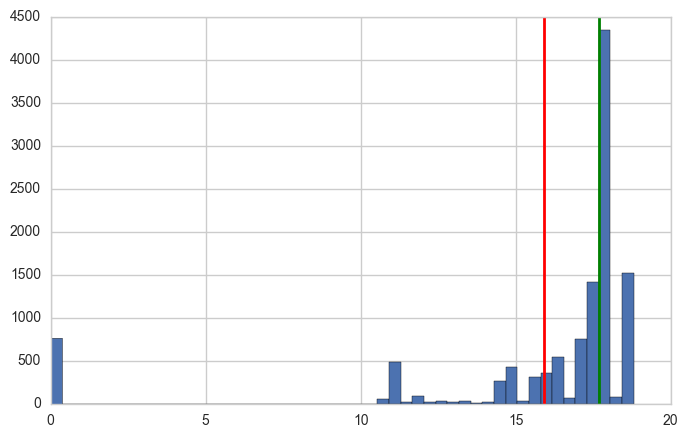

In [9]:
plt.figure(figsize=(8,5))
plt.hist(df[strTagName],50)
plt.axvline(x = df[strTagName].mean(), linewidth=2, color = 'r')
plt.axvline(x = df[strTagName].median(), linewidth=2, color = 'g')
plt.show()

In [10]:
%matplotlib --list

Available matplotlib backends: ['notebook', 'nbagg', 'wx', 'tk', 'qt', 'osx', 'gtk3', 'qt5', 'qt4', 'gtk', 'inline']
